<a href="https://colab.research.google.com/github/AbrahamKong/CMPE257-Fractal_Clustering_Assignment/blob/main/CMPE_257_Fractual_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Statement

Author: Abraham Kong

Team: Data Miners

Objective: 
Use RFM (Recency, Frequency and Monetary) value to cluster customer data provided from OList E-commerce, and use the result to treat different group of customers with different incentives to save customer from leaving the business.

### Data Set

2 downloaded 1 scraped

1. [Brazilian E-Commerce Public Dataset by Olist](https://www.kaggle.com/olistbr/brazilian-ecommerce)

2. [UCI E-commerce]()

3. Scrape Dataset: TBD


In [25]:
#Import Necessary Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import plotly.express as px
from sklearn.mixture import GaussianMixture
from sklearn.cluster import Birch
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster.elbow import kelbow_visualizer
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the Necessary Datasets

customers = pd.read_csv('olist_customers_dataset.csv')
order_items = pd.read_csv('olist_order_items_dataset.csv')
order_payments= pd.read_csv('olist_order_payments_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv')

In [3]:
# Merge all the Data into one dataframe

df1 = order_payments.merge(order_items, on="order_id")
df2 = df1.merge(orders, on="order_id")
df = df2.merge(customers, on="customer_id")
df

,order_id,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33,1,af74cc53dcffc8384b29e7abfa41902b,213b25e6f54661939f11710a6fddb871,2018-05-02 22:15:09,79.80,19.53,0a8556ac6be836b46b3e89920d59291c,delivered,2018-04-25 22:01:49,2018-04-25 22:15:09,2018-05-02 15:20:00,2018-05-09 17:36:51,2018-05-22 00:00:00,708ab75d2a007f0564aedd11139c7708,39801,teofilo otoni,MG
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39,1,a630cc320a8c872f9de830cf121661a3,eaf6d55068dea77334e8477d3878d89e,2018-07-02 11:18:58,17.00,7.39,f2c7fc58a9de810828715166c672f10a,delivered,2018-06-26 11:01:38,2018-06-26 11:18:58,2018-06-28 14:18:00,2018-06-29 20:32:09,2018-07-16 00:00:00,a8b9d3a27068454b1c98cc67d4e31e6f,2422,sao paulo,SP
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71,1,2028bf1b01cafb2d2b1901fca4083222,cc419e0650a3c5ba77189a1882b7556a,2017-12-26 09:52:34,56.99,8.72,25b14b69de0b6e184ae6fe2755e478f9,delivered,2017-12-12 11:19:55,2017-12-14 09:52:34,2017-12-15 20:13:22,2017-12-18 17:24:41,2018-01-04 00:00:00,6f70c0b2f7552832ba46eb57b1c5651e,2652,sao paulo,SP
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78,1,548e5bfe28edceab6b51fa707cc9556f,da8622b14eb17ae2831f4ac5b9dab84a,2017-12-12 12:13:20,89.90,17.88,7a5d8efaaa1081f800628c30d2b0728f,delivered,2017-12-06 12:04:06,2017-12-06 12:13:20,2017-12-07 20:28:28,2017-12-21 01:35:51,2018-01-04 00:00:00,87695ed086ebd36f20404c82d20fca87,36060,juiz de fora,MG
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45,1,386486367c1f9d4f587a8864ccb6902b,cca3071e3e9bb7d12640c9fbe2301306,2018-05-31 16:14:41,113.57,14.88,15fd6fb8f8312dbb4674e4518d6fa3b3,delivered,2018-05-21 13:59:17,2018-05-21 16:14:41,2018-05-22 11:46:00,2018-06-01 21:44:53,2018-06-13 00:00:00,4291db0da71914754618cd789aebcd56,18570,conchas,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117596,0406037ad97740d563a178ecc7a2075c,1,boleto,1,363.31,1,1302fd16bdfe85e523940c846370ef2c,a369d693961cb93b61ca2cc518872a85,2018-03-15 03:55:25,297.00,66.31,5d576cb2dfa3bc05612c392a1ee9c654,delivered,2018-03-08 16:57:23,2018-03-10 03:55:25,2018-03-12 18:19:36,2018-03-16 13:09:51,2018-04-04 00:00:00,b6027ac07fb76ebca8c97b1887865aee,12954,atibaia,SP
117597,7b905861d7c825891d6347454ea7863f,1,credit_card,2,96.80,1,fb55982be901439613a95940feefd9ee,3d871de0142ce09b7081e2b9d1733cb1,2017-08-24 10:04:56,79.00,17.80,2079230c765a88530822a34a4cec2aa0,delivered,2017-08-18 09:45:35,2017-08-18 10:04:56,2017-08-18 18:04:24,2017-08-23 22:25:56,2017-09-12 00:00:00,53b30ca78efb2b7efcd3f9e461587eb2,30210,belo horizonte,MG
117598,32609bbb3dd69b3c066a6860554a77bf,1,credit_card,1,47.77,1,848ef0a103ee21407d1fbd0f7e7ae179,3d621842b2ed28e2b474132480edac3c,2017-11-27 17:46:05,39.99,7.78,e4abb5057ec8cfda9759c0dc415a8188,invoiced,2017-11-18 17:27:14,2017-11-18 17:46:05,NaN,NaN,2017-12-05 00:00:00,d3c7da954a324253814096bcaf240e4e,1519,sao paulo,SP
117599,b8b61059626efa996a60be9bb9320e10,1,credit_card,5,369.54,1,e9c1abcc7126360336d8f56d49041a8c,679769a98cfcc6da877c8486ff1c13f3,2018-08-13 23:45:00,349.00,20.54,5d719b0d300663188169c6560e243f27,delivered,2018-08-07 23:26:13,2018-08-07 23:45:00,2018-08-09 11:46:00,2018-08-21 22:41:46,2018-08-24 00:00:00,b84dc68f02f122a88d7e7bbd37b06204,22733,rio de janeiro,RJ


In [4]:
# Drop unnecessary columns

df = df.drop(columns=['order_approved_at', 'customer_unique_id', 'order_delivered_carrier_date', 'shipping_limit_date', 'customer_city', 'customer_state', 'freight_value', 'order_item_id', 'product_id', 'order_delivered_customer_date', 'customer_zip_code_prefix', 'seller_id', 'payment_sequential'])

In [5]:
# These are the final data to start with
df.columns

Index(['order_id', 'payment_type', 'payment_installments', 'payment_value',
       'price', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_estimated_delivery_date'],
      dtype='object')

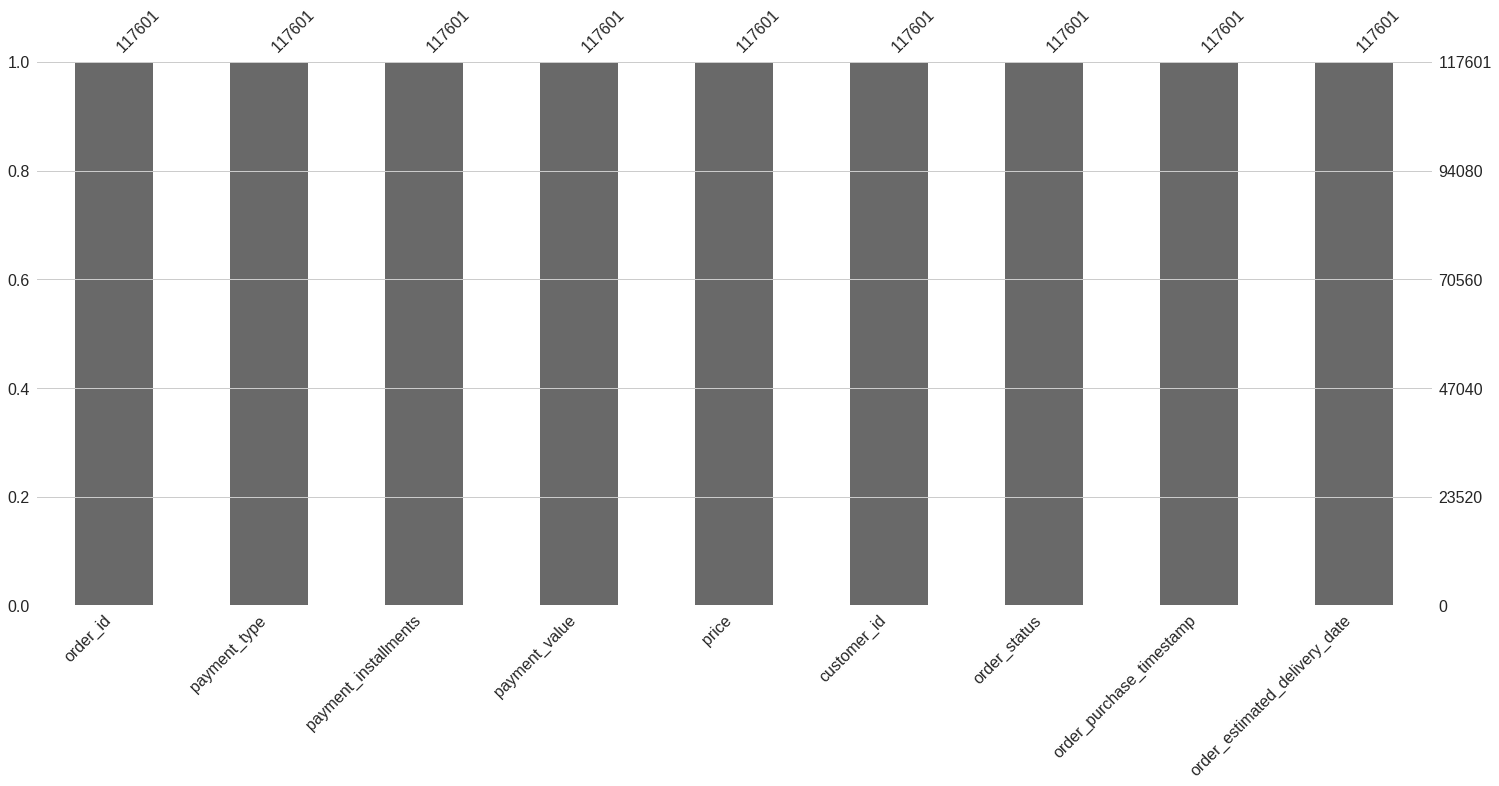

In [6]:
# Showcase missing data if any
msno.bar(df)

The goal is to find out the RFM value of each customer

### Recency

To calculate Recency, how recent the customer make a purchase, 

Assuming we are performing the anlysis on the second day of the most recent purchase.

We will set the day as 0 and increase the counter as the date went backward, 

the larger the Recency number is, the further the customer order away from the current date.

In [7]:
df.sort_values('order_purchase_timestamp',ascending=False).head()

,order_id,payment_type,payment_installments,payment_value,price,customer_id,order_status,order_purchase_timestamp,order_estimated_delivery_date
105477,54282e97f61c23b78330c15b154c867d,voucher,1,166.46,145.00,4b7decb9b58e2569548b8b4c8e20e8d7,shipped,2018-09-03 09:06:57,2018-09-06 00:00:00
51713,35a972d7f8436f405b56e36add1a7140,credit_card,1,93.75,84.99,898b7fee99c4e42170ab69ba59be0a8b,delivered,2018-08-29 15:00:37,2018-09-05 00:00:00
92252,03ef5dedbe7492bdae72eec50764c43f,credit_card,1,33.23,24.90,496630b6740bcca28fce9ba50d8a26ef,delivered,2018-08-29 14:52:00,2018-09-03 00:00:00
92428,168626408cb32af0ffaf76711caae1dc,voucher,1,61.29,45.90,6e353700bc7bcdf6ebc15d6de16d7002,delivered,2018-08-29 14:18:28,2018-09-11 00:00:00
57284,0b223d92c27432930dfe407c6aea3041,credit_card,8,510.96,209.00,e60df9449653a95af4549bbfcb18a6eb,delivered,2018-08-29 14:18:23,2018-09-04 00:00:00


In [8]:
# Change timestamp to date
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp']).dt.date

In [9]:
# Set the current date to 1
current_date = max(df['order_purchase_timestamp'])+pd.Timedelta(days=1)

In [10]:
# Create column Recency
df['Recent Date']= current_date - df['order_purchase_timestamp']

In [11]:
# Crete a new data frame Rececny
recency = df.copy()

In [12]:
recency = recency.groupby('customer_id')['Recent Date'].min().to_frame()
recency

,Recent Date
customer_id,
00012a2ce6f8dcda20d059ce98491703,294 days
000161a058600d5901f007fab4c27140,415 days
0001fd6190edaaf884bcaf3d49edf079,553 days
0002414f95344307404f0ace7a26f1d5,384 days
000379cdec625522490c315e70c7a9fb,155 days
...,...
fffcb937e9dd47a13f05ecb8290f4d3e,171 days
fffecc9f79fd8c764f843e9951b11341,159 days
fffeda5b6d849fbd39689bb92087f431,105 days


In [13]:
# Change Recency to int for future computing

recency['Recent Date'] = recency['Recent Date'].dt.days.astype('int')

### Frequency

To Calculate Frequency, How many times a customer has made a purchase

We sum up the order_id to get the number of purchases

In [14]:
# Crete a new data frame Frequency

frequency = df.copy()

In [15]:
# Sum up the number of orders for each customer
frequency = df.groupby('customer_id')['order_id'].count().to_frame()

# Rename order_id to Num of Purchase to show how many times a customer has made a purchase
frequency.rename(columns={'order_id':'Num of Purchase'},inplace=True)

In [16]:
frequency

,Num of Purchase
customer_id,
00012a2ce6f8dcda20d059ce98491703,1
000161a058600d5901f007fab4c27140,1
0001fd6190edaaf884bcaf3d49edf079,1
0002414f95344307404f0ace7a26f1d5,1
000379cdec625522490c315e70c7a9fb,1
...,...
fffcb937e9dd47a13f05ecb8290f4d3e,1
fffecc9f79fd8c764f843e9951b11341,3
fffeda5b6d849fbd39689bb92087f431,1


### Monetary

To Calculate the Monetary value, how much money has a customer spend in the store

we sum up all the price for each customer

In [17]:
# Crete a new data frame Monetary
monetary = df.copy()

In [18]:
#calculate monetary for each customer
monetary = df.groupby('customer_id')['price'].sum().to_frame()

In [19]:
monetary

,price
customer_id,
00012a2ce6f8dcda20d059ce98491703,89.80
000161a058600d5901f007fab4c27140,54.90
0001fd6190edaaf884bcaf3d49edf079,179.99
0002414f95344307404f0ace7a26f1d5,149.90
000379cdec625522490c315e70c7a9fb,93.00
...,...
fffcb937e9dd47a13f05ecb8290f4d3e,78.00
fffecc9f79fd8c764f843e9951b11341,164.70
fffeda5b6d849fbd39689bb92087f431,47.90


### Combine all 3 RFM vlaues

In [20]:
df_temp = pd.merge(recency,frequency,how='inner',left_index=True, right_index=True)
rfm = pd.merge(df_temp, monetary, how='inner', left_index=True, right_index=True)

In [21]:
# Rename the columns for better understanding
rfm.rename(columns={'Recent Date':'Recency'},inplace=True)
rfm.rename(columns={'Num of Purchase':'Frequency'},inplace=True)
rfm.rename(columns={'price':'Monetary'},inplace=True)
rfm

,Recency,Frequency,Monetary
customer_id,,,
00012a2ce6f8dcda20d059ce98491703,294,1,89.80
000161a058600d5901f007fab4c27140,415,1,54.90
0001fd6190edaaf884bcaf3d49edf079,553,1,179.99
0002414f95344307404f0ace7a26f1d5,384,1,149.90
000379cdec625522490c315e70c7a9fb,155,1,93.00
...,...,...,...
fffcb937e9dd47a13f05ecb8290f4d3e,171,1,78.00
fffecc9f79fd8c764f843e9951b11341,159,3,164.70
fffeda5b6d849fbd39689bb92087f431,105,1,47.90


### Visualizing RFM values

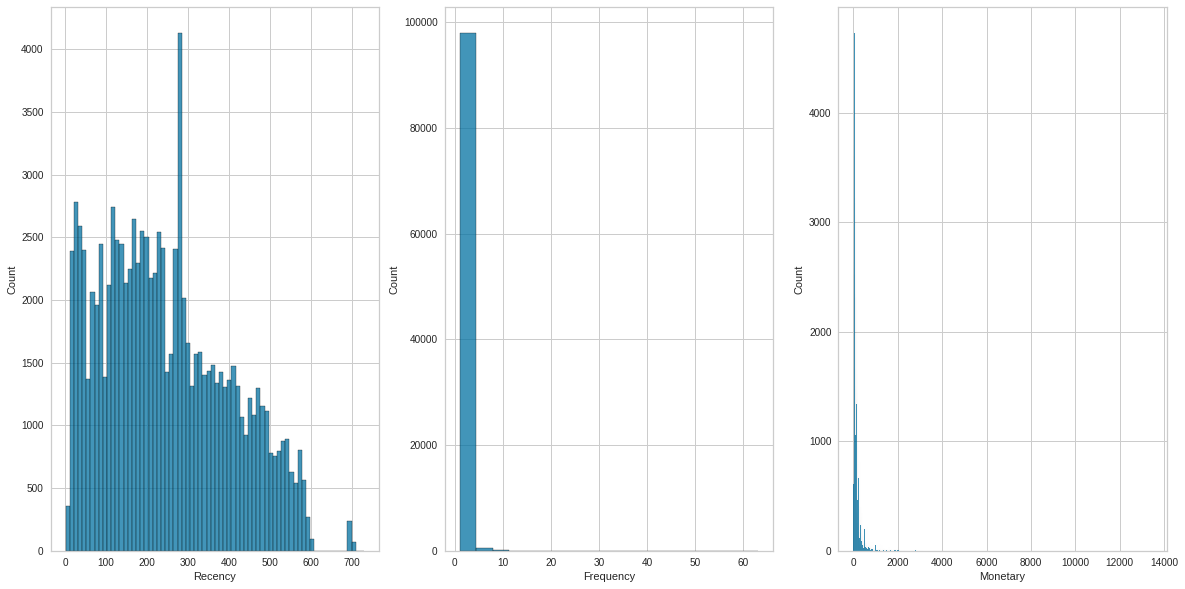

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
sns.histplot(ax=ax[0],data=rfm, x="Recency")
sns.histplot(ax=ax[1],data=rfm, x="Frequency")
sns.histplot(ax=ax[2],data=rfm, x="Monetary")

In [23]:
rfm.describe()

,Recency,Frequency,Monetary
count,98665.000000,98665.000000,98665.000000
mean,246.711276,1.191922,144.013737
std,153.386346,0.734924,241.170071
min,1.000000,1.000000,0.850000
25%,123.000000,1.000000,47.490000
50%,228.000000,1.000000,89.100000
75%,357.000000,1.000000,154.000000
max,730.000000,63.000000,13440.000000


### Perform K-Means and usign Elbow Method to find K

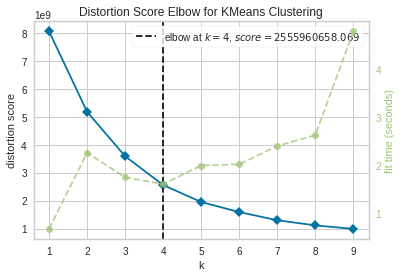

AttributeError: ignored

TypeError: ignored

In [24]:
# Use the quick method and  show the figure
kelbow_visualizer(KMeans(random_state=50), rfm, k=(1,10))

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(4,12), metric='calinski_harabasz', timings=False
)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show() 

In [ ]:
#perform Kmeans with k = 4 getting from above Elbow Method
kmeans = KMeans(n_clusters=4,max_iter=50)
kmeans.fit(rfm)

In [ ]:
# Give label to each Cluster a Customer Category
rfm['Customer Category'] = kmeans.labels_

### Silhouette Score

In [ ]:
print("Silhouette Score: ", silhouette_score(rfm, kmeans.labels_, metric='euclidean'))

### Visualizing Data

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(20, 10))
sns.scatterplot(x='Recency',y='Frequency',data=rfm,hue="Customer Category",ax=ax[0])
sns.scatterplot(x='Recency',y='Monetary',data=rfm,hue="Customer Category",ax=ax[1])
sns.scatterplot(x='Frequency',y='Monetary',data=rfm,hue="Customer Category",ax=ax[2])

### Interpretation

We can categorize the customers into 4 differnet groups

Cluster 0: Loyal Customer, more likely to keep coming to the store
We can set up VIP score and give out prizes with according VIP points, so the customer will come to the store even more often

Cluster 1 : Often Coming Customer
We can provide regular membership points as this group of customer shops, and give out according incentives like discounts

Cluster 2 : Seldom Coming Customer
We can send out more coupons to make the customers more likly to keep shopping in the store on a daily basis

Cluster 3 : Almost Losing/Lost Customer
we can showcase more ads with coupon to make the customer wanting to visit the store.